<a href="https://colab.research.google.com/github/sashapff/recommender_systems/blob/main/recsys_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data

In [1]:
!pip install kaggle

In [2]:
# from google.colab import files
# files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c kkbox-music-recommendation-challenge

sample_submission.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
test.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
song_extra_info.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
songs.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
members.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
train.csv.7z: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# !7z e train.csv.7z
# !7z e songs.csv.7z
# !7z e song_extra_info.csv.7z
# !7z e members.csv.7z

## Preprocess data

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Download and preprocess train dataset

In [7]:
train_types = {'msno': 'category',
               'song_id': 'category',
               'source_system_tab': 'category',
               'source_screen_name': 'category',
               'source_type': 'category',
               'target': np.uint8}

In [8]:
train = pd.read_csv('/content/train.csv', dtype=train_types)

In [9]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [10]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   msno                7377418 non-null  category
 1   song_id             7377418 non-null  category
 2   source_system_tab   7352569 non-null  category
 3   source_screen_name  6962614 non-null  category
 4   source_type         7355879 non-null  category
 5   target              7377418 non-null  uint8   
dtypes: category(5), uint8(1)
memory usage: 84.6 MB


Features `source_system_tab`, `source_screen_name` and `source_type` have some NaNs, so drop rows with NaNs.

In [11]:
print('Train length before drop nans', train.shape)
train = train.dropna()
print('Train length after drop nans', train.shape)

Train length before drop nans (7377418, 6)
Train length after drop nans (6959297, 6)


The size of the dataset doesn't change significant.

### Download and preprocess songs dataset

In [12]:
songs_types = {'song_id': 'category',
               'song_length': np.uint64,
               'artist_name': 'category',
               'language': np.float64}

In [13]:
songs = pd.read_csv('/content/songs.csv', dtype=songs_types)

In [14]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [15]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   song_id      2296320 non-null  category
 1   song_length  2296320 non-null  uint64  
 2   genre_ids    2202204 non-null  object  
 3   artist_name  2296320 non-null  category
 4   composer     1224966 non-null  object  
 5   lyricist     351052 non-null   object  
 6   language     2296319 non-null  float64 
dtypes: category(2), float64(1), object(3), uint64(1)
memory usage: 214.3+ MB


Features `composer` and `lyricist` have a lot Nans, so we can drop these columns at all. Features `genre_ids` and `language` has some NaNs, but we won't drop rows with NaNs and fill NaNs with the default value.

In [16]:
songs['lyricist'] = songs['lyricist'].fillna('Other')
songs['composer'] = songs['composer'].fillna('Other')

Look at unique values and the histogram of `language` feature.

(array([ 745762.,   15482.,       0.,   92518.,   41744.,   39201.,
           2385.,   14435., 1336694.,    8098.]),
 array([-1.,  5., 11., 17., 23., 29., 35., 41., 47., 53., 59.]),
 <a list of 10 Patch objects>)

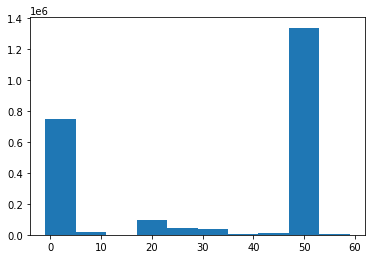

In [17]:
plt.hist(songs['language'])

I think we can change NaN to the most popular `language` (value 53).

In [18]:
songs['language'] = songs['language'].fillna(53)

Then I will change NaN in the `genre_ids` feature to the new genre with is 239239 value.

In [19]:
songs['genre_ids'] = songs['genre_ids'].fillna('239239')

In [20]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   song_id      2296320 non-null  category
 1   song_length  2296320 non-null  uint64  
 2   genre_ids    2296320 non-null  object  
 3   artist_name  2296320 non-null  category
 4   composer     2296320 non-null  object  
 5   lyricist     2296320 non-null  object  
 6   language     2296320 non-null  float64 
dtypes: category(2), float64(1), object(3), uint64(1)
memory usage: 214.3+ MB


### Download and preprocess members dataset

In [21]:
members_types = {'msno': 'category',
                 'city': np.uint64,
                 'bd': np.uint64,
                 'registered_via': np.uint64}

In [22]:
members = pd.read_csv('/content/members.csv', dtype=members_types, parse_dates=['registration_init_time', 'expiration_date'])

In [23]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [24]:
members.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    34403 non-null  category      
 1   city                    34403 non-null  uint64        
 2   bd                      34403 non-null  uint64        
 3   gender                  14501 non-null  object        
 4   registered_via          34403 non-null  uint64        
 5   registration_init_time  34403 non-null  datetime64[ns]
 6   expiration_date         34403 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), object(1), uint64(3)
memory usage: 3.2+ MB


Features `gender` have a lot Nans, so drop fill NaNs with new category `other`.

In [25]:
members['gender'] = members['gender'].fillna('other')

In [26]:
members.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    34403 non-null  category      
 1   city                    34403 non-null  uint64        
 2   bd                      34403 non-null  uint64        
 3   gender                  34403 non-null  object        
 4   registered_via          34403 non-null  uint64        
 5   registration_init_time  34403 non-null  datetime64[ns]
 6   expiration_date         34403 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), object(1), uint64(3)
memory usage: 3.2+ MB


### Download and preprocess songs extra info dataset

In [27]:
songs_extra = pd.read_csv('/content/song_extra_info.csv')

In [28]:
songs_extra.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [29]:
songs_extra.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   song_id  2295971 non-null  object
 1   name     2295969 non-null  object
 2   isrc     2159423 non-null  object
dtypes: object(3)
memory usage: 52.6+ MB


In [30]:
# Fill NaNs
songs_extra['name'] = songs_extra['name'].fillna('!!!!!!!!!!!!!!!!!!')
songs_extra['isrc'] = songs_extra['isrc'].fillna('OTHER')

In [31]:
songs_extra.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   song_id  2295971 non-null  object
 1   name     2295971 non-null  object
 2   isrc     2295971 non-null  object
dtypes: object(3)
memory usage: 52.6+ MB


Now all tables are filled.

### Check target distribution

(array([3441114.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 3518183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

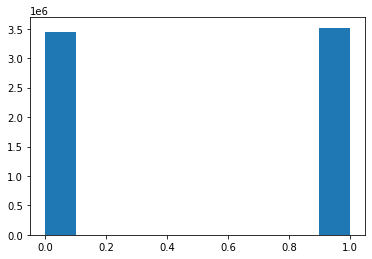

In [32]:
plt.hist(train['target'])

The targets are balanced.

## Feature engineering

In [33]:
!pip install category_encoders

In [34]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import minmax_scale

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [88]:
data = train.sample(100_000)

In [89]:
data = data.merge(songs, on='song_id')
data = data.merge(members, on='msno')

In [37]:
def encode(dataset, feature):
    encoder = TargetEncoder()
    encoder.fit(dataset[feature], dataset.target)
    dataset[feature] = encoder.transform(dataset[feature].astype('category'))

Add some new features.

In [90]:
data['first_genre'] = [int(str(i).split('|')[0]) for i in data['genre_ids']]
encode(data, 'first_genre')
# data['second_genre'] = [int(str(i).split('|')[1]) if len(str(i).split('|')) > 1 else 239239 for i in data['genre_ids']]
# encode(data, 'second_genre')
# data['third_genre'] = [int(str(i).split('|')[2]) if len(str(i).split('|')) > 2 else 239239 for i in data['genre_ids']]
# encode(data, 'third_genre')

In [92]:
member_genre_counts = data.groupby('msno').genre_ids.apply(lambda x: x.value_counts().head(1)).reset_index().rename(columns={'level_1' : 'top_genre_id', 'genre_ids' : 'top_genre_count'})
data = data.merge(member_genre_counts, on='msno')

In [41]:
# member_genre_counts = data.groupby('msno').first_genre.apply(lambda x: x.value_counts().head(1)).reset_index().rename(columns={'level_1' : 'top_first_genre_id', 'first_genre' : 'top_first_genre_count'})
# data = data.merge(member_genre_counts, on='msno')

In [42]:
# member_genre_counts = data.groupby('msno').second_genre.apply(lambda x: x.value_counts().head(1)).reset_index().rename(columns={'level_1' : 'top_second_genre_id', 'second_genre' : 'top_second_genre_count'})
# data = data.merge(member_genre_counts, on='msno')

In [91]:
# One hot encode for other features
# feature_onehot = pd.get_dummies(data.gender)
# for name in feature_onehot.columns:
#     data['gender_' + name] = feature_onehot[name]
encode(data, 'gender')

# feature_onehot = pd.get_dummies(data.registered_via)
# for name in feature_onehot.columns:
#     data['registered_via_' + str(name)] = feature_onehot[name]
encode(data, 'registered_via')

# feature_onehot = pd.get_dummies(data.city)
# for name in feature_onehot.columns:
#     data['city_' + str(name)] = feature_onehot[name]
encode(data, 'city')

# feature_onehot = pd.get_dummies(data.source_type)
# for name in feature_onehot.columns:
#     data['source_type_' + name] = feature_onehot[name]
encode(data, 'source_type')

# feature_onehot = pd.get_dummies(data.source_system_tab)
# for name in feature_onehot.columns:
#     data['source_system_tab_' + name] = feature_onehot[name]
encode(data, 'source_system_tab')

# feature_onehot = pd.get_dummies(data.language)
# for name in feature_onehot.columns:
#       data['language_' + str(name)] = feature_onehot[name]
encode(data, 'language')

# feature_onehot = pd.get_dummies(data.source_screen_name)
# for name in feature_onehot.columns:
#       data['source_screen_name_' + str(name)] = feature_onehot[name]
encode(data, 'source_screen_name')

# Split registration_init_time to 3 features
data['registration_year'] = data.registration_init_time.dt.year
data['registration_month'] = data.registration_init_time.dt.month
data['registration_day'] = data.registration_init_time.dt.day
data['registration_init_time_sec'] = data.registration_init_time.dt.year * 365 + data.registration_init_time.dt.month * 30 + data.registration_init_time.dt.day
# encode(data, 'registration_init_time')


# Split expiration_date to 3 features
data['expiration_year'] = data.expiration_date.dt.year
data['expiration_month'] = data.expiration_date.dt.month
data['expiration_day'] = data.expiration_date.dt.day
data['expiration_date_sec'] = data.expiration_date.dt.year * 365 + data.expiration_date.dt.month * 30 + data.expiration_date.dt.day
# encode(data, 'expiration_date')

# Add a new feature
data['time_on_service'] = data['expiration_date_sec'] - data['registration_init_time_sec']

encode(data, 'artist_name')
encode(data, 'lyricist')
encode(data, 'composer')

data = data.drop(columns=['bd'])

encode(data, 'top_genre_id')
# encode(data, 'top_first_genre_id')
# encode(data, 'top_second_genre_id')
encode(data, 'genre_ids')
# encode(data, 'msno')
# encode(data, 'song_id')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [43]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,gender,registered_via,registration_init_time,expiration_date,first_genre,registration_year,registration_month,registration_day,registration_init_time_sec,expiration_year,expiration_month,expiration_day,expiration_date_sec,time_on_service,top_genre_id,top_genre_count
0,cJ+2hH9XKdiBtzXWyk+UHjv4Hn00fTE4UivWNuPFgt8=,IKgN6SCjrnEiVCv+Ol20JsOYo1pMDsQA67cQGHwDXIk=,0.328892,0.419787,0.423043,0,256417,465,0.487500,0.503704,0.507576,3.0,5,0.517385,9,2007-09-02,2017-10-04,465,2007,9,2,732827,2017,10,4,736509,3682,465,3
1,cJ+2hH9XKdiBtzXWyk+UHjv4Hn00fTE4UivWNuPFgt8=,h90KlUZE/mlkkPjhbhz3hXY1zvOhqJXuiKBoFWnTDAo=,0.624745,0.638682,0.656352,0,237792,465,0.591954,0.589623,0.554217,52.0,5,0.517385,9,2007-09-02,2017-10-04,465,2007,9,2,732827,2017,10,4,736509,3682,465,3
2,cJ+2hH9XKdiBtzXWyk+UHjv4Hn00fTE4UivWNuPFgt8=,Wn5ltxI7NsFk4xGFHOFXv2ajWU9HmuEgDF+xs1EJpFo=,0.624745,0.638682,0.656352,1,230138,465,0.515021,0.559322,0.470879,52.0,5,0.517385,9,2007-09-02,2017-10-04,465,2007,9,2,732827,2017,10,4,736509,3682,465,3
3,nJAg2/7PL+geVKixibYTdtVmC1kx1Etk3NawJczpcKs=,IKgN6SCjrnEiVCv+Ol20JsOYo1pMDsQA67cQGHwDXIk=,0.624745,0.638682,0.633692,1,256417,465,0.487500,0.503704,0.507576,3.0,1,0.506475,7,2014-02-23,2017-09-22,465,2014,2,23,735193,2017,9,22,736497,1304,465,16
4,nJAg2/7PL+geVKixibYTdtVmC1kx1Etk3NawJczpcKs=,OaEbZ6TJ1NePtNUeEgWsvFLeopkSln9WQu8PBR5B3+A=,0.411242,0.520490,0.423043,1,268016,465,0.627451,0.666667,0.672566,3.0,1,0.506475,7,2014-02-23,2017-09-22,465,2014,2,23,735193,2017,9,22,736497,1304,465,16


## GBDT

In [45]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [46]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,gender,registered_via,registration_init_time,expiration_date,first_genre,registration_year,registration_month,registration_day,registration_init_time_sec,expiration_year,expiration_month,expiration_day,expiration_date_sec,time_on_service,top_genre_id,top_genre_count
0,cJ+2hH9XKdiBtzXWyk+UHjv4Hn00fTE4UivWNuPFgt8=,IKgN6SCjrnEiVCv+Ol20JsOYo1pMDsQA67cQGHwDXIk=,0.328892,0.419787,0.423043,0,256417,0.514089,0.487500,0.503704,0.507576,3.0,5,0.517385,9,2007-09-02,2017-10-04,465,2007,9,2,732827,2017,10,4,736509,3682,0.511026,3
1,cJ+2hH9XKdiBtzXWyk+UHjv4Hn00fTE4UivWNuPFgt8=,h90KlUZE/mlkkPjhbhz3hXY1zvOhqJXuiKBoFWnTDAo=,0.624745,0.638682,0.656352,0,237792,0.514089,0.591954,0.589623,0.554217,52.0,5,0.517385,9,2007-09-02,2017-10-04,465,2007,9,2,732827,2017,10,4,736509,3682,0.511026,3
2,cJ+2hH9XKdiBtzXWyk+UHjv4Hn00fTE4UivWNuPFgt8=,Wn5ltxI7NsFk4xGFHOFXv2ajWU9HmuEgDF+xs1EJpFo=,0.624745,0.638682,0.656352,1,230138,0.514089,0.515021,0.559322,0.470879,52.0,5,0.517385,9,2007-09-02,2017-10-04,465,2007,9,2,732827,2017,10,4,736509,3682,0.511026,3
3,nJAg2/7PL+geVKixibYTdtVmC1kx1Etk3NawJczpcKs=,IKgN6SCjrnEiVCv+Ol20JsOYo1pMDsQA67cQGHwDXIk=,0.624745,0.638682,0.633692,1,256417,0.514089,0.487500,0.503704,0.507576,3.0,1,0.506475,7,2014-02-23,2017-09-22,465,2014,2,23,735193,2017,9,22,736497,1304,0.511026,16
4,nJAg2/7PL+geVKixibYTdtVmC1kx1Etk3NawJczpcKs=,OaEbZ6TJ1NePtNUeEgWsvFLeopkSln9WQu8PBR5B3+A=,0.411242,0.520490,0.423043,1,268016,0.514089,0.627451,0.666667,0.672566,3.0,1,0.506475,7,2014-02-23,2017-09-22,465,2014,2,23,735193,2017,9,22,736497,1304,0.511026,16


In [47]:
X = data.drop(columns=['target', 'expiration_date', 'registration_init_time', 'msno'])
y = data['target']

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
parameters = {'model__max_depth':[3, 5, 10, 15], 
              'model__sampling_method':['uniform', 'gradient_based'], 
              'model__n_estimators':[32, 64, 128],
              'model__splitter':['best', 'random'],
              'model__criterion':['gini', 'entropy'],
              'model__min_samples_leaf':[1, 5, 10]}
clf = GridSearchCV(model, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X, y)

print('XGBClassifier', clf.best_params_)

best_model = XGBClassifier(max_depth=clf.best_params_['model__max_depth'],
                           sampling_method=clf.best_params_['model__sampling_method'],
                           tree_method='gpu_hist', gpu_id=0, 
                           n_estimators=clf.best_params_['model__n_estimators'],
                           splitter=clf.best_params_['model__splitter'],
                           criterion=clf.best_params_['model__criterion'],
                           min_samples_leaf=clf.best_params_['model__min_samples_leaf'])
# best_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_jobs=-1,
                        #    n_estimators=64, max_depth=5)
_ = best_model.fit(X, y)
score = cross_validate(best_model, X, y, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc')['test_score']

print(f'ROC AUC for the best model: {np.mean(score)}')

XGBClassifier {'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__n_estimators': 32, 'model__sampling_method': 'uniform', 'model__splitter': 'best'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC AUC for the best model: 0.768123443377859


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


### Feature imporatances

Shap doensn't work on GPU so I used feature importances from XGBoost.

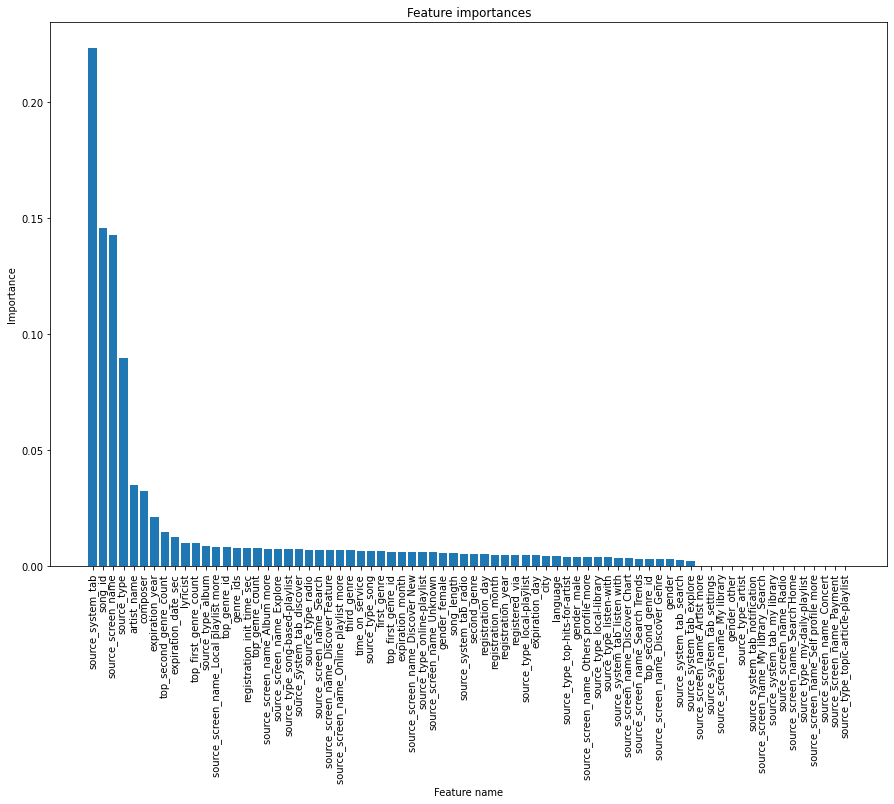

In [ ]:
importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 10))

plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Feature name')

plt.bar(range(len(X.columns)), importances[indices])
plt.xticks(range(len(X.columns)),X.columns[indices],rotation=90)
plt.show()

In [48]:
!pip install shap

In [49]:
from shap import TreeExplainer
import shap
from sklearn.model_selection import train_test_split

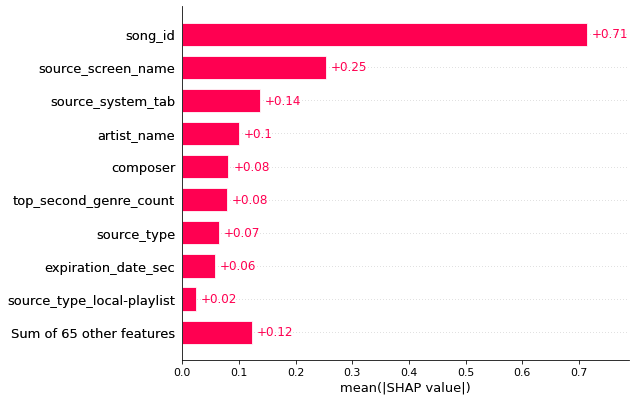

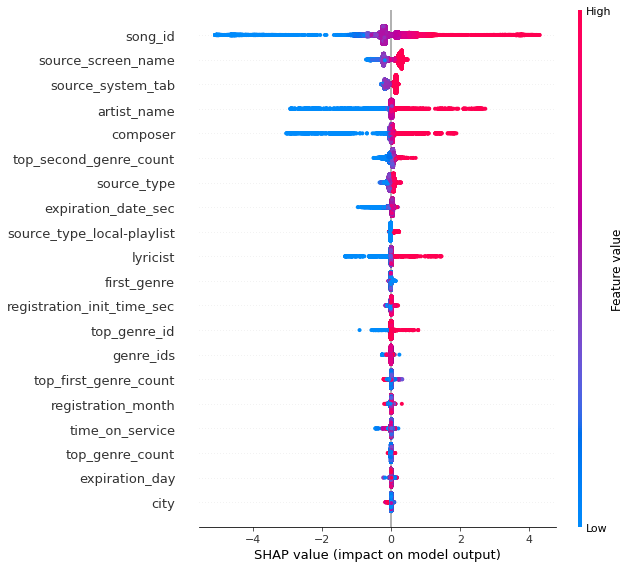

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = XGBClassifier(n_estimators=64, max_depth=5)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test)

## Build embeddings

In [48]:
from tqdm import tqdm
from gensim.models import Word2Vec
import multiprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

In [94]:
emb_data = data.merge(songs_extra, on='song_id')

Build dictionary for Word2Vec based on song's names, artists, composers and lyricists. The words in the sentences are so hard because we want to interpretate the similars.

In [95]:
targeted = emb_data.loc[emb_data.target == 1, ['msno']]
targeted['song'] = emb_data.apply(lambda x: 
                                  str(x['artist_name']) + ' | '  
                                  + 
                                  str(x['name']) 
                                  + ' | ' 
                                  + str(x['composer']) + ' | ' + 
                                  str(x['lyricist'])
                                , axis=1)

In [ ]:
targeted.head()

,msno,song
2513175,lO+aqcXqoddiIeyGRMib1syQz49lKoWw3r/rpWXd1VI=,"BANGTAN BOYS | Burning Up (FIRE) | Pdogg| ""hit..."
595389,gRoIzb7mNqxkbvTnwYTIUOwu876QMsybux9zA2xVibg=,Bii畢書盡+陳勢安+陳彥允+李玉璽 | Love More - 三立、東森偶像劇<料理高校...
5619602,DgEJg7TwYediP2BflkGBc9doc5KaYoCXU3me0BUicTs=,Francois Couture| Denis Veilleux | Les brises ...
4650367,NSBR1BrOO3XDapGQCMi19nRidHD4qzoEXbGGnBap/e0=,林俊傑 (JJ Lin) | 會讀書 | 林俊傑 | 張思爾
6179108,eBI/hC7oKMUr6pKnPurBw/FJwk1jE8RQua+X31U08gU=,孫盛希 (Shi Shi) | 微笑帶過 (Passing Smile) | 孫盛希 | M...


In [96]:
targeted_numpy = targeted.to_numpy()
dictionary = [[str(x[1]) for x in targeted_numpy[targeted_numpy[:, 0] == user]] for user in targeted.msno.unique()]

Then we can train Word2Vec model and look at similars for some songs.

In [97]:
model = Word2Vec(dictionary, window=20, size=50, negative=20, min_count=1, workers = multiprocessing.cpu_count())

model.train(dictionary, total_examples=model.corpus_count, epochs=10, report_delay=1)

(506960, 507330)

In [54]:
def get_similar(name):
    for item in model.wv.most_similar(name, topn=5):
        print(f'score {item[1]} for {item[0]}')

In [ ]:
dictionary[30:50]

In [ ]:
get_similar('Maroon 5 | Wipe Your Eyes | Adam Levine| Jonathan Rotem| Ross Golan| Sanjeet Singh Kang | Other')

score 0.9983172416687012 for One Direction | End of the Day | Ed Drewett|John Ryan|Julian Bunetta|Liam Payne|Louis Tomlinson|Jacob Kasher|Gamal Lewis|Wayne Hector | Ed Drewett|John Ryan|Julian Bunetta|Liam Payne|Louis Tomlinson|Jacob Kasher|Gamal Lewis|Wayne Hector
score 0.9981319308280945 for Air Supply | Young Love | Graham Russell | Graham Russell
score 0.9975491762161255 for The Wanted | Satellite | Ryan Tedder|Noel Zancanella|Evan Bogart | Other
score 0.9969307780265808 for 游學志 | Warm | 人工衛星 | 李焯雄
score 0.8406094908714294 for John Legend | All Of Me (Album Version) | John Stephens|Toby Gad | John Stephens|Toby Gad


In [ ]:
get_similar('One Direction | End of the Day | Ed Drewett|John Ryan|Julian Bunetta|Liam Payne|Louis Tomlinson|Jacob Kasher|Gamal Lewis|Wayne Hector | Ed Drewett|John Ryan|Julian Bunetta|Liam Payne|Louis Tomlinson|Jacob Kasher|Gamal Lewis|Wayne Hector')

score 0.9991381168365479 for The Wanted | Satellite | Ryan Tedder|Noel Zancanella|Evan Bogart | Other
score 0.9988506436347961 for 游學志 | Warm | 人工衛星 | 李焯雄
score 0.9983172416687012 for Maroon 5 | Wipe Your Eyes | Adam Levine| Jonathan Rotem| Ross Golan| Sanjeet Singh Kang | Other
score 0.997550904750824 for Air Supply | Young Love | Graham Russell | Graham Russell
score 0.8443043231964111 for Train | Hey| Soul Sister | Other | Other


In [ ]:
get_similar('Bring Me The Horizon | Shadow Moses | Other | Other')

score 0.9749314188957214 for Danger Danger | Hearts On The Highway | Other | Other
score 0.9553470611572266 for Halestorm | Here's To Us | Other | Other
score 0.9414724111557007 for Fastway | Don't Stop The Fight | Other | Other
score 0.9125471115112305 for KIX | Cold Blood | Other | Other
score 0.9015350341796875 for Three Days Grace | Animal I Have Become | 寬限三日樂團|Barry Stock|G. Brown | 寬限三日樂團|Barry Stock|G. Brown


In [ ]:
get_similar('Three Days Grace | Animal I Have Become | 寬限三日樂團|Barry Stock|G. Brown | 寬限三日樂團|Barry Stock|G. Brown')

score 0.901535153388977 for Bring Me The Horizon | Shadow Moses | Other | Other
score 0.8848183155059814 for Mr. Big | Wild World | Other | Other
score 0.8232430219650269 for Danger Danger | Hearts On The Highway | Other | Other
score 0.8137735724449158 for Halestorm | Here's To Us | Other | Other
score 0.8115438222885132 for 獅子合唱團 (Lion) | 為你 (For You) | Jam Hsiao | Jam Hsiao


Now we want to create and add as the new feature a column with the scalar product of average word2vec representation for a user and the word2vec representation for a song at each row. 

In [98]:
user_w2v = {user: np.array([model.wv[word] for word in dictionary[i]]).mean(axis=0) for (i, user) in enumerate(targeted.msno.unique())}
user_song = emb_data[['msno', 'target']].merge(targeted, on='msno')
user_song['cos'] = user_song.apply(lambda x: cosine_similarity([user_w2v[x['msno']]], [model.wv[x['song']]]), axis=1).apply(lambda x: x[0][0])

Then we look at roc auc score for predictions only on normalized scalar product. We got the value more than 0.5, so this embedding coulb be used.

In [107]:
roc_auc_score(user_song['target'], user_song['cos'])

0.501143664754616

Compare score and the shap values for subsample of 1000 elements (because whole dataset is quite large and shap values are crashed) for data before adding embedding with scalar product and with it (column `cos`).

In [100]:
data = data.merge(user_song[['cos', 'msno']], on='msno')

In [70]:
data = data.sample(1000)

In [104]:
X = data.drop(columns=['cos', 'target', 'msno', 'registration_init_time', 'expiration_date', 'song_id'])
y = data['target']

In [74]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

best_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_jobs=-1,
                           n_estimators=64, max_depth=5)
_ = best_model.fit(X, y)
score = cross_validate(best_model, X, y, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc')['test_score']

print(f'ROC AUC for the best model: {np.mean(score)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC AUC for the best model: 0.7264038958992677


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


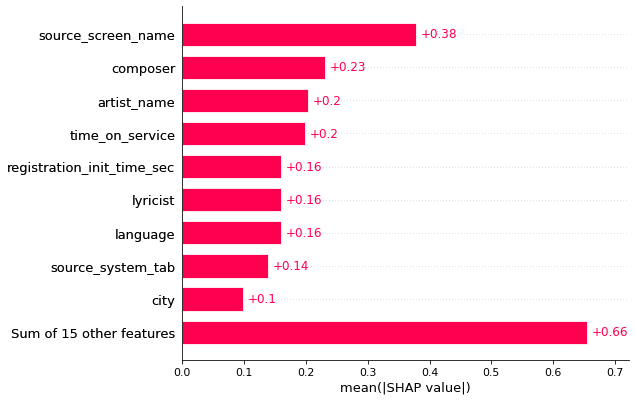

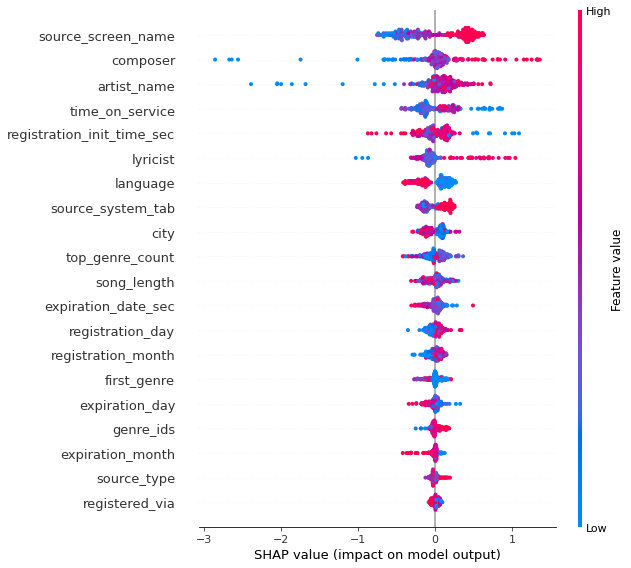

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = XGBClassifier(n_estimators=64, max_depth=5)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test)

In [86]:
X = data.drop(columns=['target', 'msno', 'registration_init_time', 'expiration_date', 'song_id'])
y = data['target']

In [84]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

best_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_jobs=-1,
                           n_estimators=64, max_depth=5)
_ = best_model.fit(X, y)
score = cross_validate(best_model, X, y, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc')['test_score']

print(f'ROC AUC for the best model: {np.mean(score)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC AUC for the best model: 0.7728916074758357


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


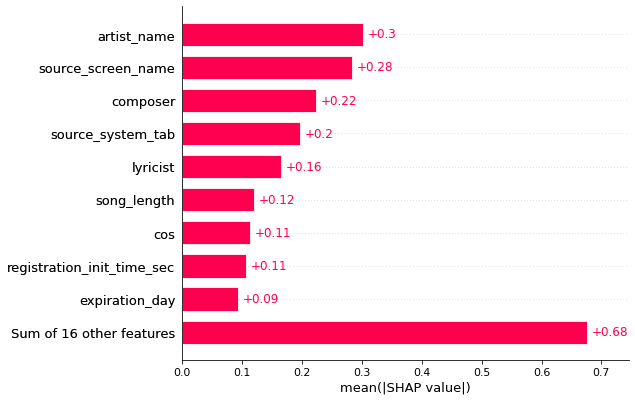

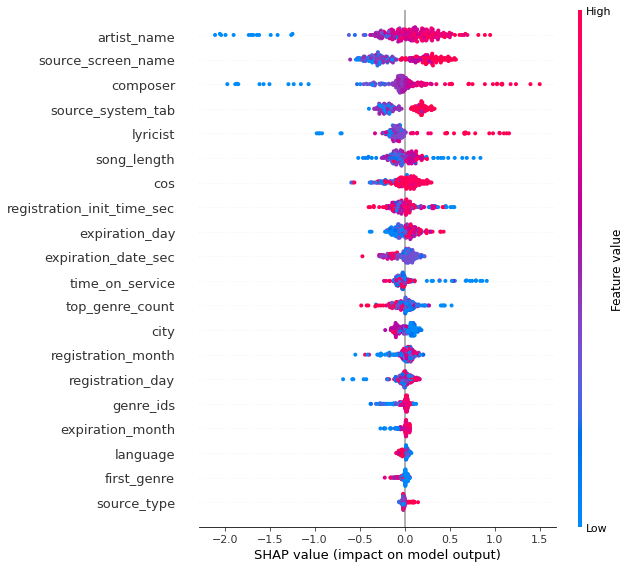

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = XGBClassifier(n_estimators=64, max_depth=5)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test)

The score with embedding is a little more. We can see that `cos` has a quite significant importance. So it's better to use it for this task. I think if I would test on the entire dataset the scores will be higher but the colab doesn't give me that much RAM.